In [1]:
from importlib import reload
import pandas as pd
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from knn import CustomKNeighborsRegressor
from sklearn import tree, neighbors

from evaluation import evaluator

reload(evaluator)

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from gradient import MyGDRegressor

from evaluation import evaluator

from importlib import reload

# Infrared Thermography Temperature

In [2]:
infrared_df = pd.read_csv("./infrared/FLIR_groups1and2.csv", header=None)
# Get actual header
infrared_headers = infrared_df.iloc[2]
# Remove Round header and measurements generic term
infrared_df = infrared_df[3:]
infrared_df.columns = infrared_headers

# Drop NaN columns and NaN rows
infrared_df = infrared_df.dropna(axis=1, how='all')
infrared_df = infrared_df.dropna()
# Remove all but one Round and insignificant columns
filtered_columns = [col for col in infrared_df.columns if
                    not col.endswith(('2', '3', '4')) and col not in ["Cosmetics", "Time", "Date", "SubjectID"]]
infrared_df = infrared_df[filtered_columns]

infrared_df = infrared_df.reset_index(drop=True)

for col in infrared_df.columns:
    try:
        infrared_df[col] = pd.to_numeric(infrared_df[col])
    except ValueError:
        print(col)

Gender
Age
Ethnicity


In [3]:
print(infrared_df['Age'].unique())
print(infrared_df['Ethnicity'].unique())
print(infrared_df['Gender'].unique())

['18-20' '21-25' '>60' '26-30' '31-40' '51-60' '41-50' '21-30']
['Asian' 'Hispanic/Latino' 'White' 'Black or African-American'
 'Multiracial' 'American Indian or Alaskan Native']
['Female' 'Male']


In [4]:
infrared_df['Age'] = infrared_df['Age'].replace(['21-25', '26-30'], '21-30')
print(infrared_df['Age'].unique())

['18-20' '21-30' '>60' '31-40' '51-60' '41-50']


In [5]:
feature_mappings = {
    'Age': ['18-20', '21-30', '31-40', '41-50', '51-60', '>60']
}
ordinal_cols = ['Age']
one_hot_cols = ['Ethnicity', 'Gender']
ordinal_categories = [feature_mappings[col] for col in ordinal_cols]

numerical_cols = infrared_df.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_cols = numerical_cols.tolist()

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_cols)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

ordinal_categories

[['18-20', '21-30', '31-40', '41-50', '51-60', '>60']]

In [6]:
infrared_df = infrared_df.drop('aveOralF', axis=1)  # Set has two targets so drop one and chose the other
X = infrared_df.drop('aveOralM', axis=1)
y = infrared_df[('aveOralM')]

ir_X_train, ir_X_test, ir_y_train, ir_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
ir_X_train = pipeline.fit_transform(ir_X_train)
ir_X_test = pipeline.transform(ir_X_test)
ir_X_train

array([[2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        3.57142857e-01, 7.11462451e-01, 7.64720877e-04],
       [2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.42857143e-01, 3.10276680e-01, 3.05888351e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.95238095e-01, 3.26086957e-01, 7.64720877e-04],
       ...,
       [2.00000000e-01, 0.00000000e+00, 1.00000000e+00, ...,
        3.69047619e-01, 1.56126482e-01, 7.64720877e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        7.14285714e-01, 2.13438735e-01, 7.64720877e-04],
       [2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.52380952e-01, 3.16205534e-01, 3.18633699e-03]])

# Black Friday

In [8]:
data, meta = arff.loadarff("./black_friday.arff")
black_df = pd.DataFrame(data)

for column in black_df.columns:
    # replace missing values with pd.NA
    black_df[column] = black_df[column].replace(b'?', pd.NA)
    black_df[column] = black_df[column].replace(b'', pd.NA)
    black_df[column] = black_df[column].replace(b'NONE', pd.NA)
    # decode bytes to string for each column
    black_df[column] = black_df[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
black_df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10.0,A,2,0.0,1.0,6.0,14.0,15200.0
1,M,46-50,7.0,B,2,1.0,1.0,8.0,17.0,19215.0
2,M,26-35,20.0,A,1,1.0,1.0,2.0,5.0,15665.0
3,F,51-55,9.0,A,1,0.0,5.0,8.0,14.0,5378.0
4,F,51-55,9.0,A,1,0.0,2.0,3.0,4.0,13055.0
...,...,...,...,...,...,...,...,...,...,...
166816,F,46-50,0.0,B,4+,1.0,3.0,4.0,12.0,8047.0
166817,M,26-35,6.0,B,2,0.0,6.0,8.0,14.0,16493.0
166818,M,26-35,6.0,B,2,0.0,2.0,3.0,10.0,3425.0
166819,M,26-35,6.0,B,2,0.0,1.0,2.0,15.0,15694.0


In [9]:
y = black_df[('Purchase')]
X = black_df.drop('Purchase', axis=1)  # Features

bf_X_train, bf_X_test, bf_y_train, bf_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(black_df['Age'].unique())

['0-17' '46-50' '26-35' '51-55' '36-45' '18-25' '55+']


In [11]:
feature_mappings = {
    'Age': ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
}
ordinal_cols = ['Age']
one_hot_cols = ['City_Category', 'Gender', 'Stay_In_Current_City_Years']
ordinal_categories = [feature_mappings[col] for col in ordinal_cols]

numerical_cols = [col for col in infrared_df.select_dtypes(include="number").columns if col != 'Purchase']

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_cols),
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])



In [12]:

bf_X_train = pipeline.fit_transform(bf_X_train)
bf_X_test = pipeline.transform(bf_X_test)
bf_X_train

array([[0.33333333, 1.        , 0.        , ..., 0.5       , 0.85714286,
        0.86666667],
       [0.33333333, 1.        , 0.        , ..., 0.85714286, 0.92857143,
        0.86666667],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.28571429,
        0.73333333],
       ...,
       [0.16666667, 0.        , 1.        , ..., 0.        , 0.28571429,
        0.73333333],
       [0.5       , 1.        , 0.        , ..., 0.07142857, 0.14285714,
        0.13333333],
       [0.66666667, 0.        , 1.        , ..., 0.        , 0.        ,
        0.13333333]])

# Power plant

In [13]:
ccpp_df = pd.read_excel("./CCPP/Folds5x2_pp.xlsx")
ccpp_df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [14]:
X = ccpp_df.drop('PE', axis=1)
y = ccpp_df.PE
# Split for training
ccpp_X_train, ccpp_X_test, ccpp_y_train, ccpp_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
cols_to_scale = remaining_columns = [col for col in ccpp_df.columns if col != "PE"]
preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), cols_to_scale)],
    remainder='passthrough')

ccpp_X_train = preprocessor.fit_transform(ccpp_X_train)
ccpp_X_test = preprocessor.transform(ccpp_X_test)
ccpp_X_train

array([[0.59585185, 0.42099644, 0.40584014, 0.84294611],
       [0.27496296, 0.26814947, 0.80623608, 0.65894936],
       [0.19792593, 0.25355872, 0.69685721, 0.83184403],
       ...,
       [0.76977778, 0.78060498, 0.49418461, 0.26279448],
       [0.30962963, 0.28718861, 0.54392477, 0.85445437],
       [0.29451852, 0.2702847 , 0.62360802, 0.96669374]])

## knn evaluation

### neighbors

### metric

### leaf size

## gradient

# datasets

In [18]:
## Decision Tree Regressor
## Gradient Descent
## KNN

## Infrared Thermo Temperature

In [ ]:
tree_reg = tree.DecisionTreeRegressor()
knn_reg = neighbors.KNeighborsRegressor(20)

## Black Friday

In [ ]:
tree_reg = tree.DecisionTreeRegressor()
knn_reg = neighbors.KNeighborsRegressor(20)

## Power Plant

In [ ]:
tree_reg = tree.DecisionTreeRegressor()
knn_reg = neighbors.KNeighborsRegressor(20)

## Gradient Descent Evaluation

### Max iterations

Evaluating Model:  MyGDRegressor
Hyperparameters:  {'learning_rate': 0.001}
Hyperparameter  max_iter  value:  200
R2:  -124.96654295362431
MSE:  26.096947160104335
Hyperparameter  max_iter  value:  500
R2:  -106.65905894218085
MSE:  22.304119067195646
Hyperparameter  max_iter  value:  1000
R2:  -93.13681950981277
MSE:  19.50266750967606
Hyperparameter  max_iter  value:  2000
R2:  -73.12133297532588
MSE:  15.355986317777438
Hyperparameter  max_iter  value:  5000
R2:  -39.175455694138634
MSE:  8.323295375098507
Hyperparameter  max_iter  value:  10000
R2:  -17.541319473610912
MSE:  3.841272636652251
Hyperparameter  max_iter  value:  20000
R2:  -5.799836784818523
MSE:  1.4087469347799308
Hyperparameter  max_iter  value:  50000
R2:  -0.35287629691910816
MSE:  0.28028030623856826
Hyperparameter  max_iter  value:  100000
R2:  0.3784535483416388
MSE:  0.12876804051414115
Evaluating Model:  MyGDRegressor
Hyperparameters:  {'learning_rate': 0.001}
Hyperparameter  max_iter  value:  200
R2:  -125.

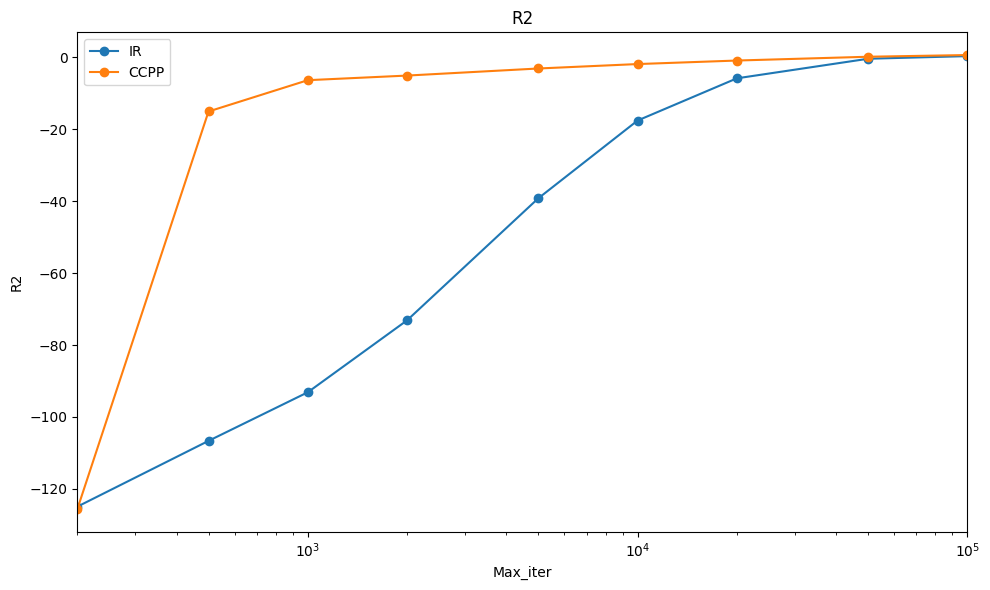

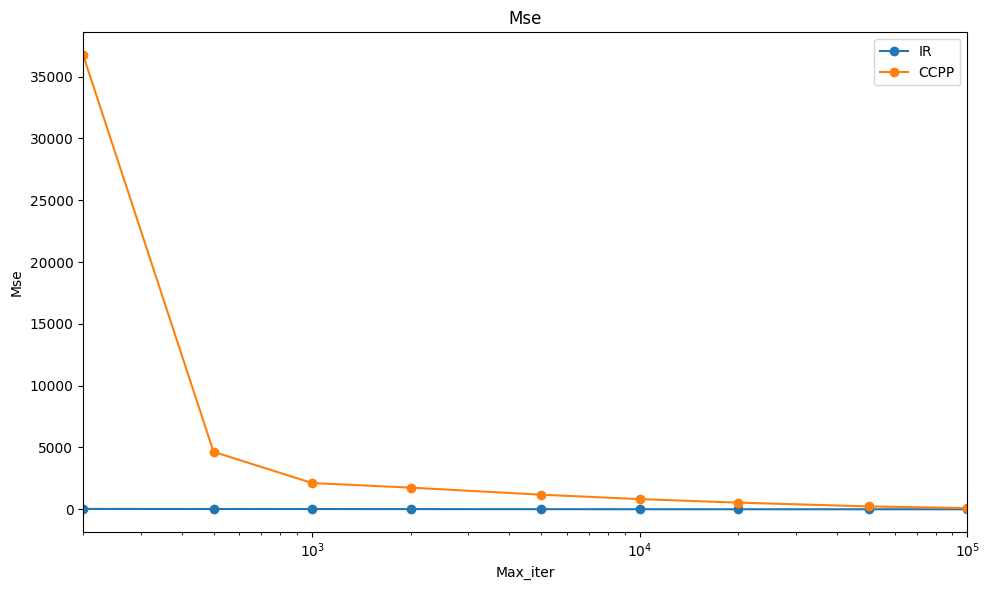

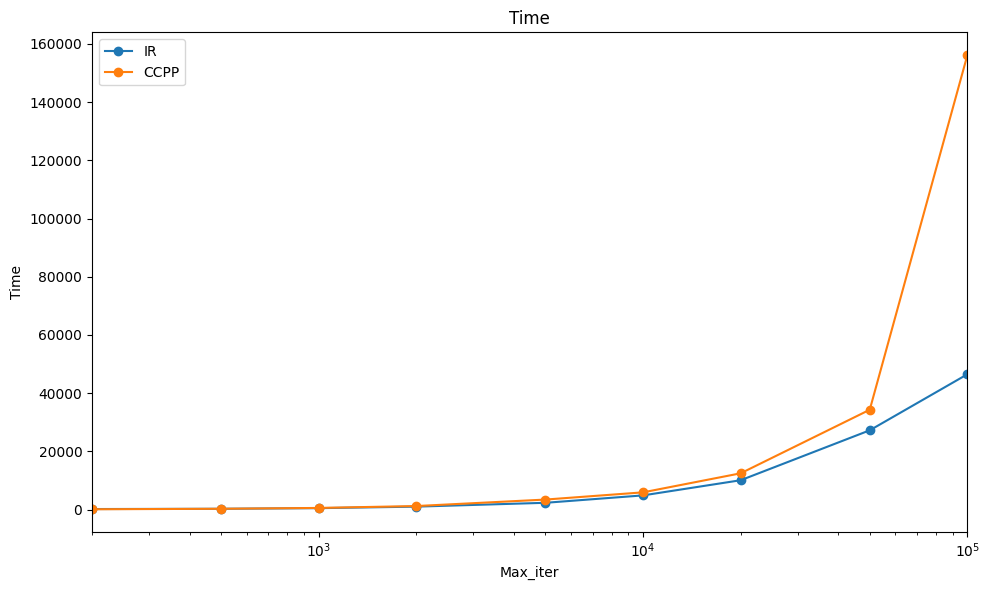

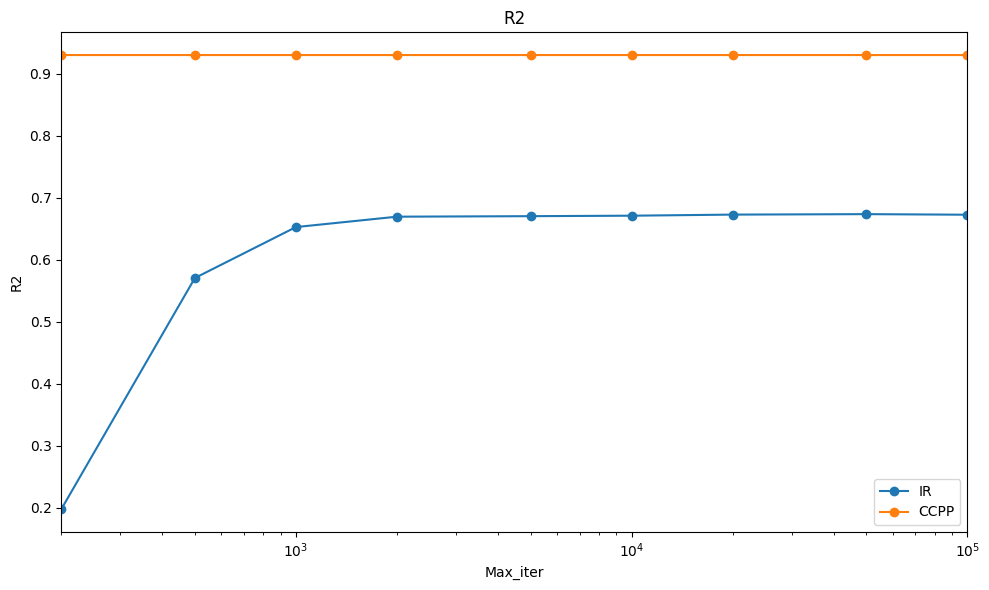

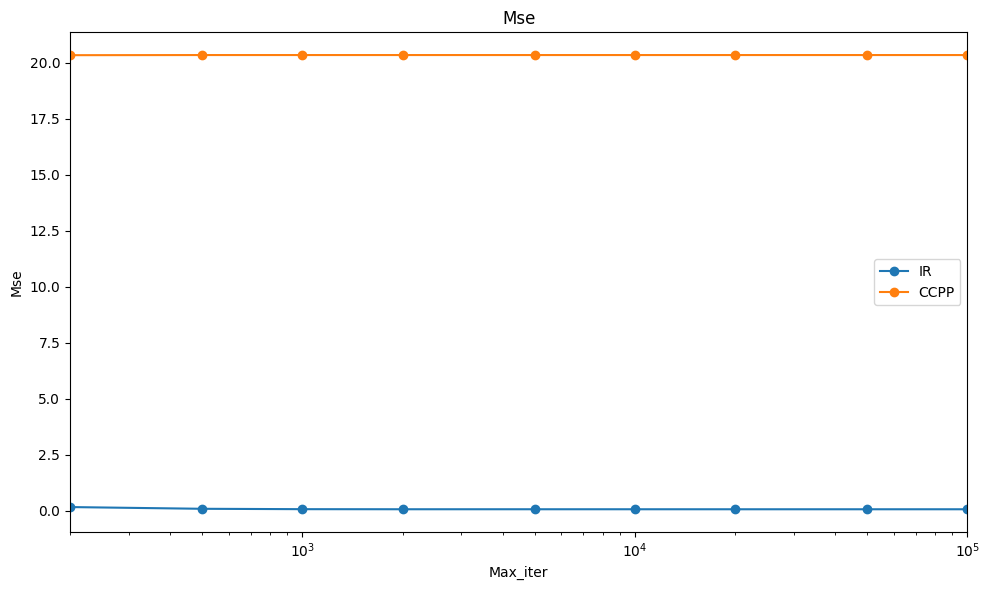

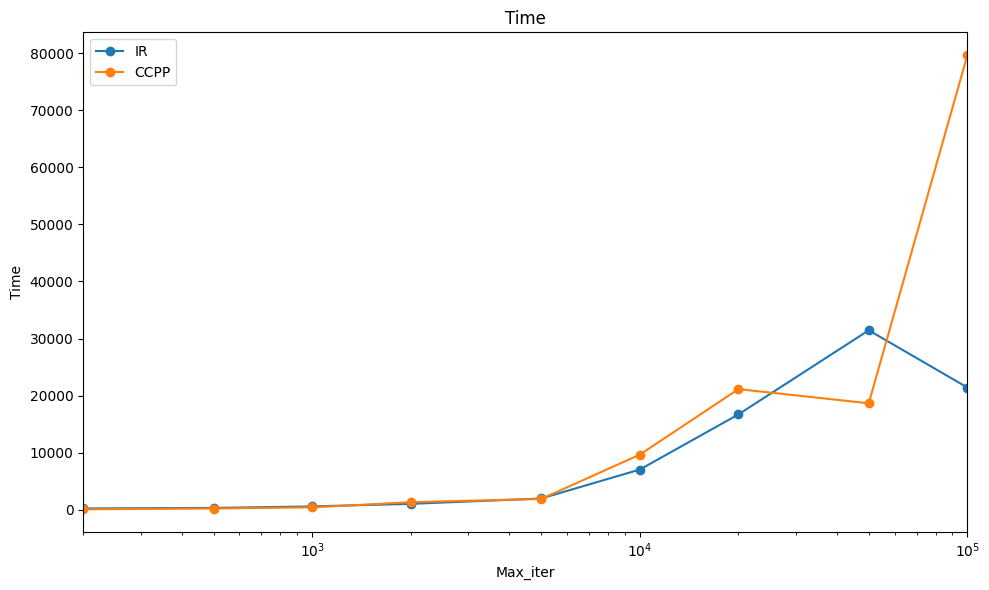

In [44]:
import numpy as np

reload(evaluator)

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

learning_rate = 0.001

hyperparameters_my_gd = {
    #'max_iter': 1000,
    'learning_rate': learning_rate,
}

hyperparameters_sgd = {
    #'max_iter':1000, 
    'eta0': learning_rate,
    'loss': 'squared_error',
    'learning_rate': 'constant',
    'tol': None,
    'shuffle': False,
    'penalty': None,
}

base_values = [100, 200, 500]
scaled_values = base_values.copy()
for i in range(1, 3):
    for value in base_values:
        scaled_values.append(value * (10 ** i))
scaled_values.append(100000)
scaled_values.pop(0)  # Remove 100 as its not a useful max_iter value

hyperparameters_iterator = {'max_iter': scaled_values}

# Remove large values as dataset bf is too large to run algorithms with such large max_iter
bf_scaled_values = [x for x in scaled_values if x not in [10000, 20000, 50000, 100000]]

bf_hyperparameters_iterator = {'max_iter': bf_scaled_values}

# MyGDRegressor

ir_max_iter_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                       ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                       hyperparameters=hyperparameters_my_gd,
                                                       hyperparameters_iterate=hyperparameters_iterator)

ccpp_max_iter_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                       ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                       hyperparameters=hyperparameters_my_gd,
                                                       hyperparameters_iterate=hyperparameters_iterator)

# bf_max_iter_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
#                                                   bf_X_train, bf_y_train, bf_X_test, bf_y_test,
#                                                   hyperparameters=hyperparameters_my_gd,
#                                                   hyperparameters_iterate=bf_hyperparameters_iterator)

# Sklearn SGDRegressor

ir_max_iter_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                       ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                       hyperparameters=hyperparameters_sgd,
                                                       hyperparameters_iterate=hyperparameters_iterator)

ccpp_max_iter_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                       ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                       hyperparameters=hyperparameters_sgd,
                                                       hyperparameters_iterate=hyperparameters_iterator)

# bf_max_iter_sgd_regressor = evaluator.evaluate2(SGDRegressor,
#                                                 bf_X_train, bf_y_train, bf_X_test, bf_y_test,
#                                                 hyperparameters=hyperparameters_sgd,
#                                                 hyperparameters_iterate=bf_hyperparameters_iterator)

# Draw diagrams for IR and CCPP datasets:

evaluator.draw_diagram2_list({"IR": ir_max_iter_my_sg_regressor, "CCPP": ccpp_max_iter_my_sg_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'], logaritmic=True)

evaluator.draw_diagram2_list({"IR": ir_max_iter_sgd_regressor, "CCPP": ccpp_max_iter_sgd_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'], logaritmic=True)

# Draw diagram for BF dataset
# evaluator.draw_diagram2_list(
#     {"BF - Custom": bf_max_iter_my_sg_regressor, "BF - Sklearn": bf_max_iter_sgd_regressor},
#     x_axis='max_iter', y_axis=['R2', 'MSE', 'time'], logaritmic=True)





### Learning Rate

Evaluating Model:  MyGDRegressor
Hyperparameters:  {'max_iter': 10000}
Hyperparameter  learning_rate  value:  1.0000000000000002e-06
R2:  -4662.657858344304
MSE:  966.1869719392414
Hyperparameter  learning_rate  value:  2.0000000000000003e-06
R2:  -3301.424196975145
MSE:  684.1752400908505
Hyperparameter  learning_rate  value:  5e-06
R2:  -1221.4977484024664
MSE:  253.26930782843843
Hyperparameter  learning_rate  value:  1e-05
R2:  -315.6880580798809
MSE:  65.609417581535
Hyperparameter  learning_rate  value:  2e-05
R2:  -125.38767032901552
MSE:  26.184193651161124
Hyperparameter  learning_rate  value:  5e-05
R2:  -106.66204770978803
MSE:  22.304738261058475
Hyperparameter  learning_rate  value:  0.0001
R2:  -93.13875969567522
MSE:  19.503069465042508
Hyperparameter  learning_rate  value:  0.0002
R2:  -73.12317344797047
MSE:  15.356367615193633
Hyperparameter  learning_rate  value:  0.0005
R2:  -39.17664758148852
MSE:  8.323542302738668
Hyperparameter  learning_rate  value:  0.001
R2: 

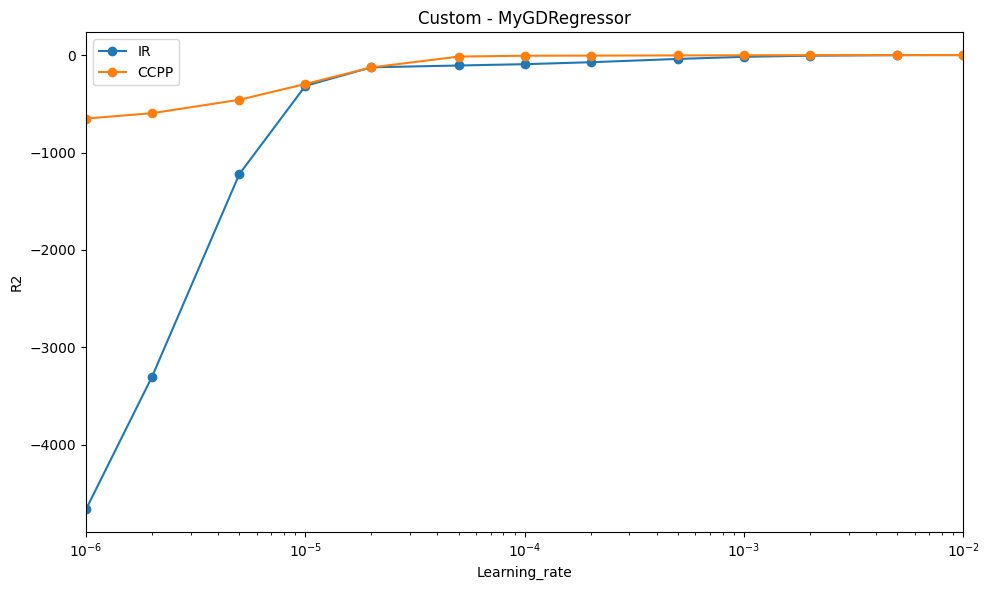

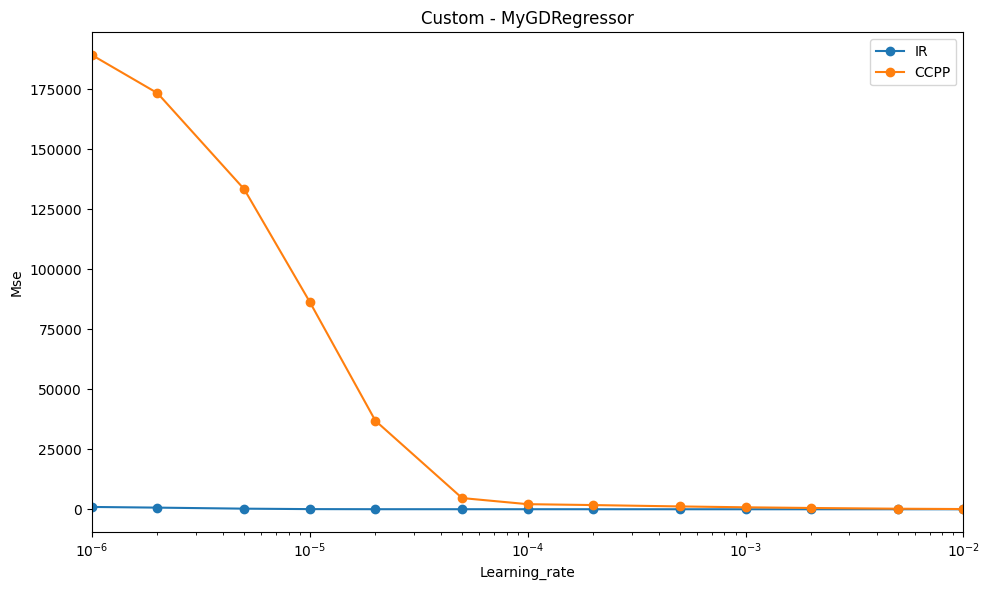

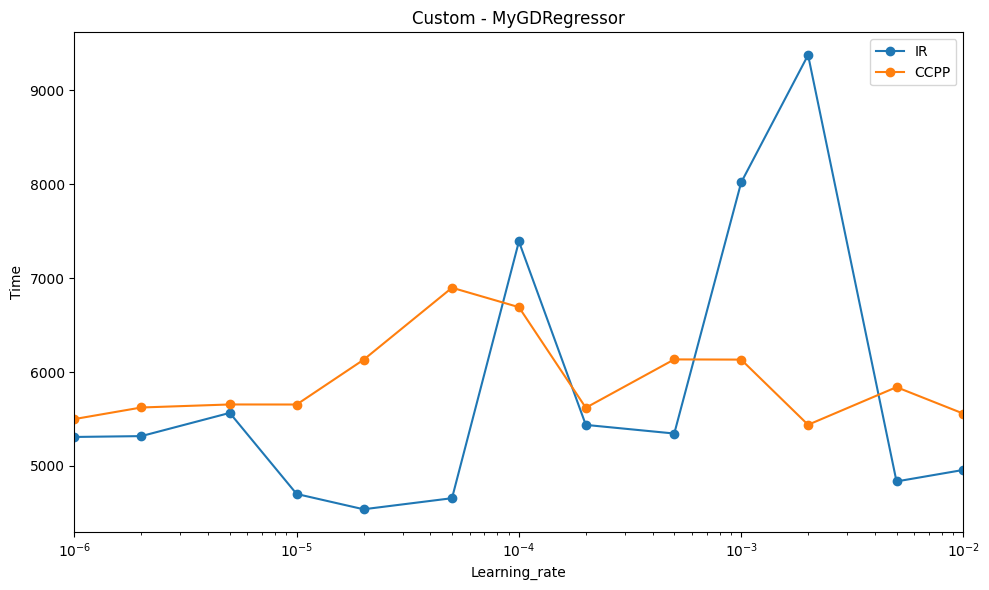

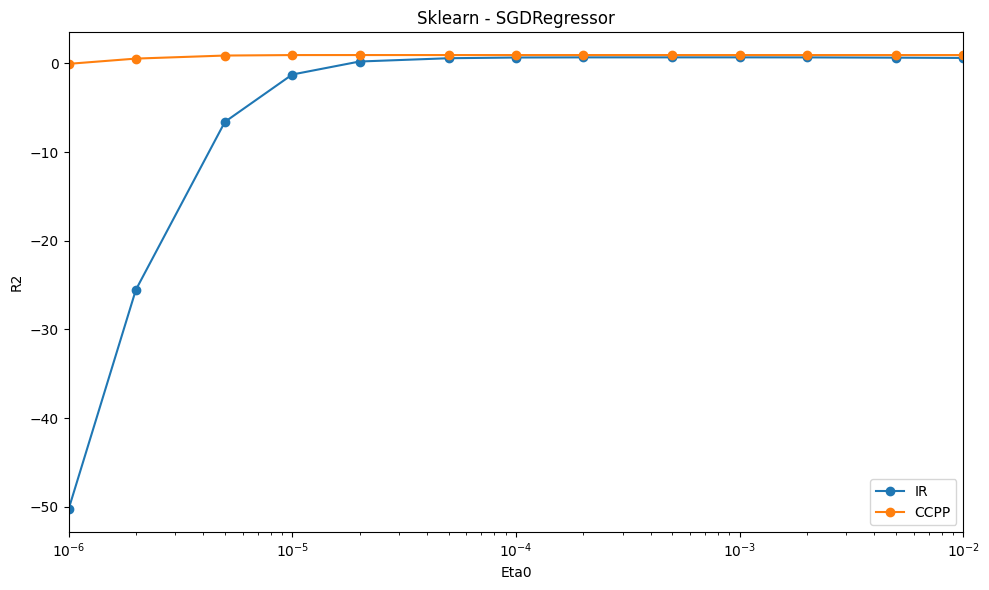

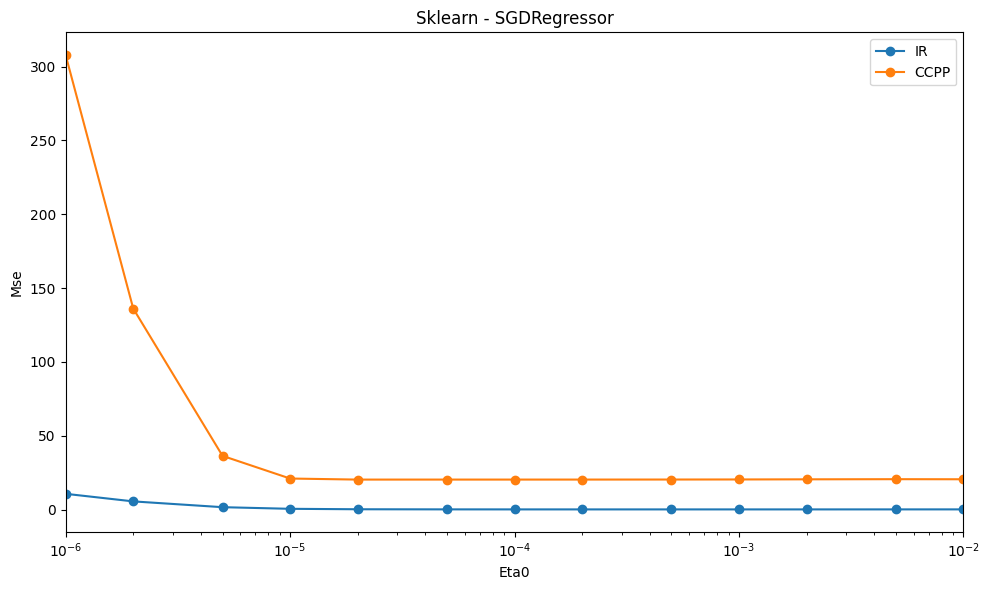

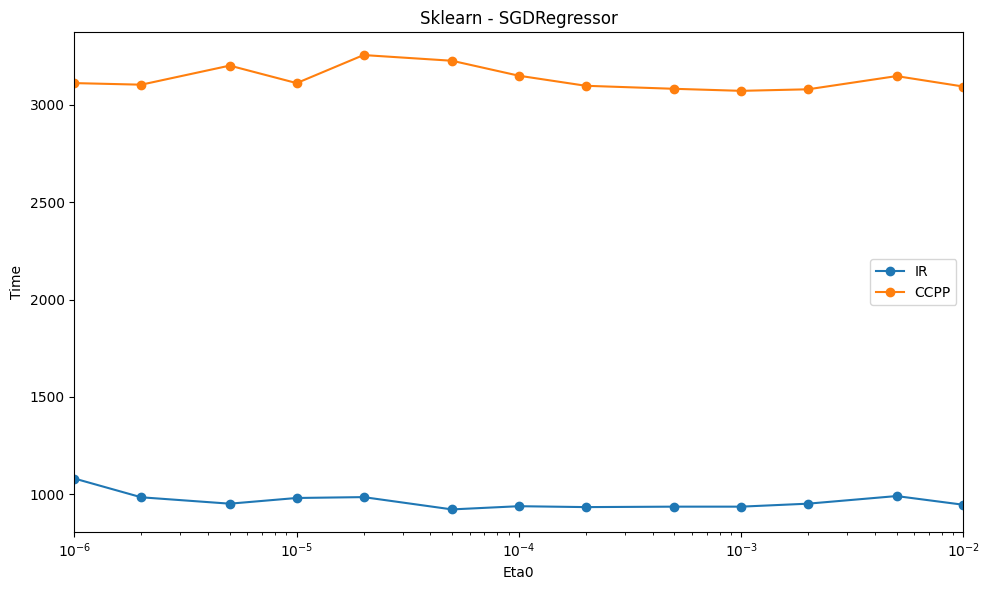

In [43]:
reload(evaluator)

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

max_iter = 10000

hyperparameters_my_gd = {
    'max_iter': max_iter,
}

hyperparameters_sgd = {
    'max_iter': max_iter,
    #'eta0': learning_rate,
    'loss': 'squared_error',
    'learning_rate': 'constant',
    'tol': None,
    'shuffle': False,
    'penalty': None,
}

base_values = [0.05, 0.02, 0.01]
scaled_values = base_values.copy()
for i in range(1, 5):
    for value in base_values:
        scaled_values.append(value * (10 ** -i))
scaled_values.reverse()
scaled_values.pop()
scaled_values.pop()  # Remove 0.5 and 0.2 as it is not a sensible learning rate

my_sg_hyperparameters_iterator = {'learning_rate': scaled_values}
sgd_hyperparameters_iterator = {'eta0': scaled_values}

# MyGDRegressor

ir_learning_rate_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                       ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                       hyperparameters=hyperparameters_my_gd,
                                                       hyperparameters_iterate=my_sg_hyperparameters_iterator)

ccpp_learning_rate_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                         ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                         hyperparameters=hyperparameters_my_gd,
                                                         hyperparameters_iterate=my_sg_hyperparameters_iterator)

# bf_learning_rate_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
#                                                        bf_X_train, bf_y_train, bf_X_test, bf_y_test,
#                                                        hyperparameters=hyperparameters_my_gd,
#                                                        hyperparameters_iterate=my_sg_hyperparameters_iterator)

# Sklearn SGDRegressor

ir_learning_rate_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                hyperparameters=hyperparameters_sgd,
                                                hyperparameters_iterate=sgd_hyperparameters_iterator)

ccpp_learning_rate_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                  ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                  hyperparameters=hyperparameters_sgd,
                                                  hyperparameters_iterate=sgd_hyperparameters_iterator)

# bf_learning_rate_sgd_regressor = evaluator.evaluate2(SGDRegressor,
#                                                 bf_X_train, bf_y_train, bf_X_test, bf_y_test,
#                                                 hyperparameters=hyperparameters_sgd,
#                                                 hyperparameters_iterate=sgd_hyperparameters_iterator)

# Draw diagrams for IR and CCPP datasets:

evaluator.draw_diagram2_list({"IR": ir_learning_rate_my_sg_regressor, "CCPP": ccpp_learning_rate_my_sg_regressor}, x_axis='learning_rate', y_axis=['R2', 'MSE', 'time'], logaritmic=True, title="Custom - MyGDRegressor")

evaluator.draw_diagram2_list({"IR": ir_learning_rate_sgd_regressor, "CCPP": ccpp_learning_rate_sgd_regressor}, x_axis='eta0', y_axis=['R2', 'MSE', 'time'], logaritmic=True, title="Sklearn - SGDRegressor")

# Draw diagram for BF dataset
# evaluator.draw_diagram2_list(
#     {"BF - Custom": bf_learning_rate_my_sg_regressor, "BF - Sklearn": bf_learning_rate_sgd_regressor},
#     x_axis=['learning_rate', 'eta0'], y_axis=['R2', 'MSE', 'time'], logaritmic=True)

# Save data in pickle file
# import pickle
# 
# with open('gradient_eval.pkl', 'wb') as f:
#     pickle.dump({"sklearn_results_gradient_learning_rate": {
#         "ir": ir_max_iter_sgd_regressor,
#         "ccpp": ccpp_max_iter_sgd_regressor,
#         "bf": bf_max_iter_sgd_regressor
#     },
#         "custom_results": {
#         "ir": ir_learning_rate_my_sg_regressor,
#         "ccpp": ccpp_learning_rate_my_sg_regressor,
#         "bf": bf_learning_rate_my_sg_regressor
#     },
#     }, f)

### Runtime comparison

### Best run comparison

In [ ]:
# ir_X_train, ir_X_test, ir_y_train, ir_y_test

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

max_iter = 1000
learning_rate = 0.0001

sgd_regressor = SGDRegressor(max_iter=max_iter, alpha=learning_rate, eta0=learning_rate,
                             loss='squared_error',
                             learning_rate='constant', tol=None,
                             shuffle=False,
                             penalty=None
                             )
sgd_regressor.fit(ir_X_train, ir_y_train)
sgd_y_pred = sgd_regressor.predict(ir_X_test)

my_gd_regressor = MyGDRegressor(max_iter=max_iter, alpha=learning_rate)
my_gd_regressor.fit(ir_X_train, ir_y_train)
my_y_pred = my_gd_regressor.predict(ir_X_test)

# Calc mean squared error for evaluation
sgd_mse = mean_squared_error(ir_y_test, sgd_y_pred)
my_mse = mean_squared_error(ir_y_test, my_y_pred)
print("sklearn sgd regressor: ", sgd_mse)
print("my regressor: ", my_mse)